In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
!pip install albumentations==0.4.6

     |████████████████████████████████| 117 kB 5.3 MB/s 
     |████████████████████████████████| 948 kB 43.3 MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-py3-none-any.whl size=65174 sha256=38ed6aa6c9dcc396f925728069b7dab6ec51b0028ef2d395c2fbfba179c3c627
  Stored in directory: /root/.cache/pip/wheels/cf/34/0f/cb2a5f93561a181a4bcc84847ad6aaceea8b5a3127469616cc
Successfully built albumentations
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


# Discriminator 

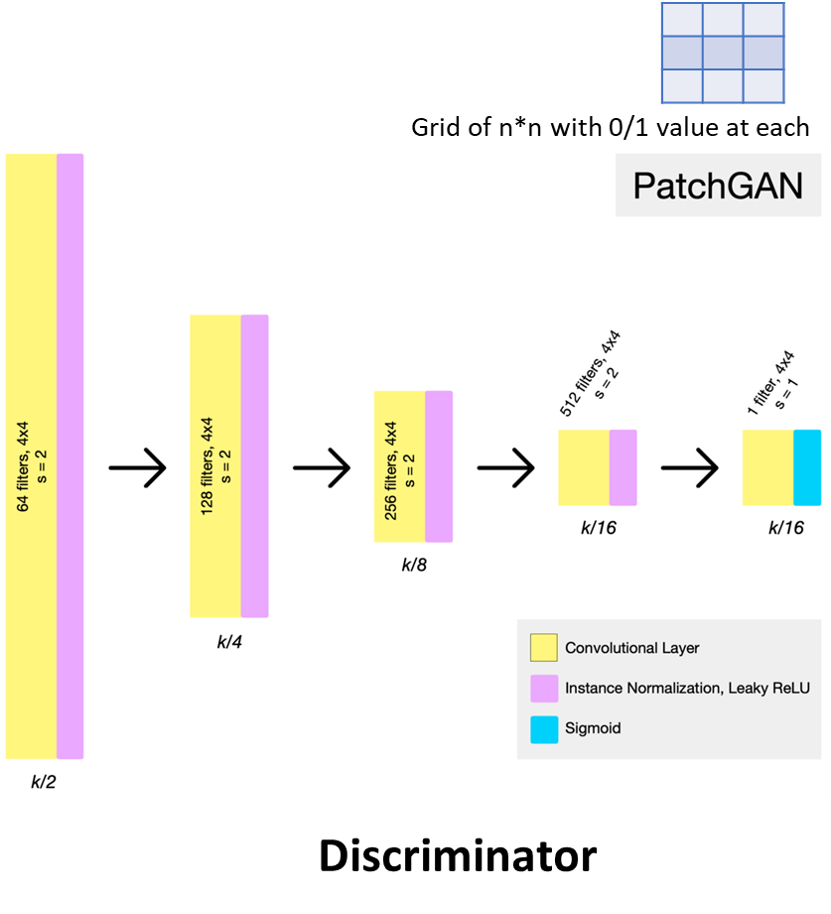

In [4]:
import torch
import torch.nn as nn

#Compact ReLu using instance normalization (NOT Batch norm)
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 4, stride, 1, bias=True, padding_mode="reflect"),
            #karnel size is always 4 in paper; padding = 1; padding_mode=reflect reduces artifacts
            nn.InstanceNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True), #adding Leaky ReLU activation function
        )
        
    def forward(self, x):
        return self.conv(x)
    
class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[64, 128, 256, 512]): #in_channels=3 for RGB
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(
                in_channels,
                features[0],
                kernel_size=4,
                stride=2,
                padding=1,
                padding_mode="reflect"
            ),
            nn.LeakyReLU(0.2, inplace=True) #adding Leaky ReLU activation function
        )
        
        layers = []
        in_channels = features[0]
        for feature in features[1:]:
            layers.append(Block(in_channels, feature, stride=1 if feature==features[-1] else 2))
            in_channels = feature
        layers.append(nn.Conv2d(in_channels, 1, kernel_size = 4, stride=1, padding=1, padding_mode="reflect"))
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.initial(x)
        return torch.sigmoid(self.model(x)) # adding sigmoid at the end

# Generator

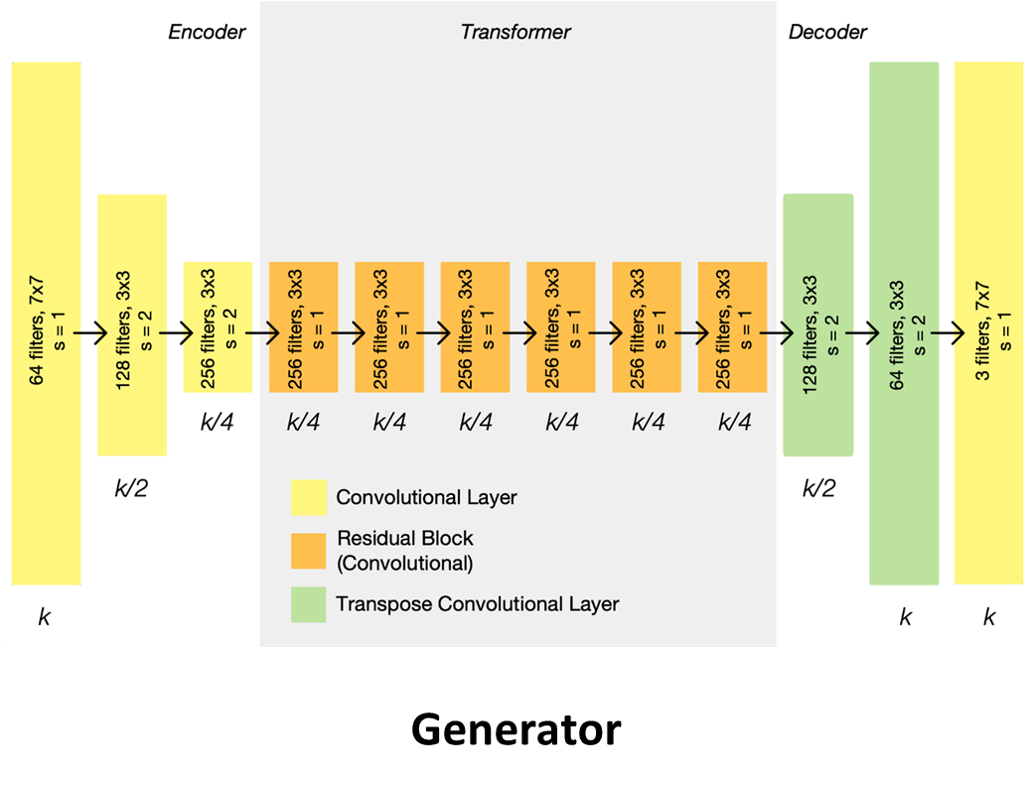

In [5]:
import torch
import torch.nn as nn

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, use_act=True, **kwargs):
        #down=True> meaning down sampling; kwargs> key word argument; use_act> activation function
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, padding_mode="reflect", **kwargs)
            #Here, Key word arguments are kernel size, padding, stride
            if down
            else nn.ConvTranspose2d(in_channels, out_channels, **kwargs), #Used Decoder or Transpose Conv Layer
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True) if use_act else nn.Identity()
        )

    def forward(self, x):
        return self.conv(x)

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            ConvBlock(channels, channels, kernel_size=3, padding=1), # Here stride = 1 by default
            ConvBlock(channels, channels, use_act=False, kernel_size=3, padding=1),
        )

    def forward(self, x):
        return x + self.block(x)

class Generator(nn.Module):
    def __init__(self, img_channels, num_features = 64, num_residuals=9):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(img_channels, num_features, kernel_size=7, stride=1, padding=3, padding_mode="reflect"),
            nn.InstanceNorm2d(num_features),
            nn.ReLU(inplace=True),
        )
        self.down_blocks = nn.ModuleList(
            [
                ConvBlock(num_features, num_features*2, kernel_size=3, stride=2, padding=1),
                ConvBlock(num_features*2, num_features*4, kernel_size=3, stride=2, padding=1),
            ]
        )
        self.res_blocks = nn.Sequential(
            *[ResidualBlock(num_features*4) for _ in range(num_residuals)]
        )
        self.up_blocks = nn.ModuleList(
            [
                ConvBlock(num_features*4, num_features*2, down=False, kernel_size=3, stride=2, padding=1, output_padding=1),
                ConvBlock(num_features*2, num_features*1, down=False, kernel_size=3, stride=2, padding=1, output_padding=1),
            ]
        )

        self.last = nn.Conv2d(num_features*1, img_channels, kernel_size=7, stride=1, padding=3, padding_mode="reflect")

    def forward(self, x):
        x = self.initial(x)
        for layer in self.down_blocks:
            x = layer(x)
        x = self.res_blocks(x)
        for layer in self.up_blocks:
            x = layer(x)
        return torch.tanh(self.last(x))

# Dataset

In [12]:
from PIL import Image
import os
from torch.utils.data import Dataset
import numpy as np

class HumanAnimeDataset(Dataset):
    def __init__(self, root_anime, root_human, transform=None):
        self.root_anime = root_anime
        self.root_human = root_human
        self.transform = transform

        self.anime_images = os.listdir(root_anime)
        self.human_images = os.listdir(root_human)
        self.length_dataset = max(len(self.anime_images), len(self.human_images)) # 1000, 1500
        self.anime_len = len(self.anime_images)
        self.human_len = len(self.human_images)

    def __len__(self):
        return self.length_dataset

    def __getitem__(self, index):
        anime_img = self.anime_images[index % self.anime_len] # No. of index might be bigger than anime_images
        human_img = self.human_images[index % self.human_len]

        anime_path = os.path.join(self.root_anime, anime_img)
        human_path = os.path.join(self.root_human, human_img)

        anime_img = np.array(Image.open(anime_path).convert("RGB"))
        human_img = np.array(Image.open(human_path).convert("RGB"))

        if self.transform:
            augmentations = self.transform(image=anime_img, image0=human_img)
            anime_img = augmentations["image"]
            human_img = augmentations["image0"]

        return anime_img, human_img

class HumanAnimeDataset_pickle(Dataset):
    def __init__(self, anime_images, human_images, transform=None):
        # self.root_anime = root_anime
        # self.root_human = root_human
        self.transform = transform

        self.anime_images = anime_images
        self.human_images = human_images
        self.length_dataset = max(len(self.anime_images), len(self.human_images)) # 1000, 1500
        self.anime_len = len(self.anime_images)
        self.human_len = len(self.human_images)

    def __len__(self):
        return self.length_dataset

    def __getitem__(self, index):
        anime_img = self.anime_images[index % self.anime_len] # No. of index might be bigger than anime_images
        human_img = self.human_images[index % self.human_len]

        anime_path = os.path.join(self.root_anime, anime_img)
        human_path = os.path.join(self.root_human, human_img)

        anime_img = np.array(Image.open(anime_path).convert("RGB"))
        human_img = np.array(Image.open(human_path).convert("RGB"))

        if self.transform:
            augmentations = self.transform(image=anime_img, image0=human_img)
            anime_img = augmentations["image"]
            human_img = augmentations["image0"]

        return anime_img, human_img

# Config File

In [7]:
import pickle

pickle_in = open(r"/content/drive/MyDrive/Colab Notebooks/CVPR_Project/face2anime/pickle_train/human_train_data.pkl","rb")
human_train_data = pickle.load(pickle_in)

pickle_in = open("/content/drive/MyDrive/Colab Notebooks/CVPR_Project/face2anime/pickle_train/anime_train_data.pkl","rb")
anime_train_data = pickle.load(pickle_in)

In [8]:
#!pip install albumentations==0.4.6

In [14]:
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2

DEVICE = "cuda" if torch.cuda.is_available() else "cpu" #Code is running on CPU/GPU
TRAIN_DIR = "/content/drive/MyDrive/Colab Notebooks/CVPR_Project/face2anime/train"
VAL_DIR = "/content/drive/MyDrive/Colab Notebooks/CVPR_Project/face2anime/val"



BATCH_SIZE = 1
LEARNING_RATE = 1e-5
LAMBDA_IDENTITY = 0.0
LAMBDA_CYCLE = 10
NUM_WORKERS = 4
NUM_EPOCHS = 10
LOAD_MODEL = False
SAVE_MODEL = True
CHECKPOINT_GEN_H = "genh.pth.tar"
CHECKPOINT_GEN_Z = "genz.pth.tar"
CHECKPOINT_CRITIC_H = "critich.pth.tar"
CHECKPOINT_CRITIC_Z = "criticz.pth.tar"

transforms = A.Compose(
    [
        A.Resize(width=256, height=256),
        A.HorizontalFlip(p=0.5),
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255),
        ToTensorV2(),
     ],
    additional_targets={"image0": "image"},
)

# Utils File

In [10]:
import random, torch, os, numpy as np
import torch.nn as nn
#import config
import copy

def save_checkpoint(model, optimizer, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)


def load_checkpoint(checkpoint_file, model, optimizer, lr):
    print("=> Loading checkpoint")
    checkpoint = torch.load(checkpoint_file, map_location=DEVICE)
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

    # If we don't do this then it will just have learning rate of old checkpoint
    # and it will lead to many hours of debugging \:
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr


def seed_everything(seed=42):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Train Dataset

In [ ]:
import torch
#from dataset import HumanAnimeDataset
import sys
#from utils import save_checkpoint, load_checkpoint
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
#import config
from tqdm import tqdm
from torchvision.utils import save_image
#from discriminator_model import Discriminator
#from generator_model import Generator


#***************************************TRAIN FUNCTION********************************************
def train_fn(disc_H, disc_Z, gen_Z, gen_H, loader, opt_disc, opt_gen, l1, mse, d_scaler, g_scaler):
    H_reals = 0
    H_fakes = 0
    loop = tqdm(loader, leave=True)

    for idx, (anime, human) in enumerate(loop):
        anime = anime.to(DEVICE)
        human = human.to(DEVICE)
        
        # Train Discriminators H and Z
        fake_human = gen_H(anime)
        D_H_real = disc_H(human)
        D_H_fake = disc_H(fake_human.detach())
        H_reals += D_H_real.mean().item()
        H_fakes += D_H_fake.mean().item()
        D_H_real_loss = mse(D_H_real, torch.ones_like(D_H_real))
        D_H_fake_loss = mse(D_H_fake, torch.zeros_like(D_H_fake))
        D_H_loss = D_H_real_loss + D_H_fake_loss #Loss Calculation for Hourse

        fake_anime = gen_Z(human)
        D_Z_real = disc_Z(anime)
        D_Z_fake = disc_Z(fake_anime.detach())
        D_Z_real_loss = mse(D_Z_real, torch.ones_like(D_Z_real))
        D_Z_fake_loss = mse(D_Z_fake, torch.zeros_like(D_Z_fake))
        D_Z_loss = D_Z_real_loss + D_Z_fake_loss #Loss Calculation for Anime

        # put it togethor
        D_loss = (D_H_loss + D_Z_loss)/2


        opt_disc.zero_grad()
        d_scaler.scale(D_loss).backward()
        d_scaler.step(opt_disc)
        d_scaler.update()




        # Train Generators H and Z
        # adversarial loss for both generators
        D_H_fake = disc_H(fake_human)
        D_Z_fake = disc_Z(fake_anime)
        loss_G_H = mse(D_H_fake, torch.ones_like(D_H_fake))
        loss_G_Z = mse(D_Z_fake, torch.ones_like(D_Z_fake))

        # cycle loss
        cycle_anime = gen_Z(fake_human)
        cycle_human = gen_H(fake_anime)
        cycle_anime_loss = l1(anime, cycle_anime)
        cycle_human_loss = l1(human, cycle_human)

        # identity loss (remove these for efficiency if you set lambda_identity=0)
        identity_anime = gen_Z(anime)
        identity_human = gen_H(human)
        identity_anime_loss = l1(anime, identity_anime)
        identity_human_loss = l1(human, identity_human)

        # add all togethor
        G_loss = (
            loss_G_Z
            + loss_G_H
            + cycle_anime_loss * LAMBDA_CYCLE
            + cycle_human_loss * LAMBDA_CYCLE
            + identity_human_loss * LAMBDA_IDENTITY
            + identity_anime_loss * LAMBDA_IDENTITY
        )
        


        opt_gen.zero_grad()
        g_scaler.scale(G_loss).backward()
        g_scaler.step(opt_gen)
        g_scaler.update()

        if idx % 200 == 0:
            save_image(fake_human*0.5+0.5, f"/content/drive/MyDrive/Colab Notebooks/CVPR_Project/saved_images/human_{idx}.png") #*0.5+0.5 to improve normalizarion
            save_image(fake_anime*0.5+0.5, f"/content/drive/MyDrive/Colab Notebooks/CVPR_Project/saved_images/anime_{idx}.png")

        loop.set_postfix(H_real=H_reals/(idx+1), H_fake=H_fakes/(idx+1))


#********************MAIN FUNCTION*********************************************
def main():
    disc_H = Discriminator(in_channels=3).to(DEVICE) #Discriminator Human
    disc_Z = Discriminator(in_channels=3).to(DEVICE) #Discriminator Zeebra
    gen_Z = Generator(img_channels=3, num_residuals=9).to(DEVICE) #Generate Anime
    gen_H = Generator(img_channels=3, num_residuals=9).to(DEVICE) #Generate Human
    opt_disc = optim.Adam(
        list(disc_H.parameters()) + list(disc_Z.parameters()),
        lr=LEARNING_RATE,
        betas=(0.5, 0.999),
    )

    opt_gen = optim.Adam(
        list(gen_Z.parameters()) + list(gen_H.parameters()),
        lr=LEARNING_RATE,
        betas=(0.5, 0.999),
    )

    L1 = nn.L1Loss() # Cycle Consistency Loss
    mse = nn.MSELoss() # Mean Square Error Loss

    if LOAD_MODEL:
        load_checkpoint(
            CHECKPOINT_GEN_H, gen_H, opt_gen, LEARNING_RATE,
        )
        load_checkpoint(
            CHECKPOINT_GEN_Z, gen_Z, opt_gen, LEARNING_RATE,
        )
        load_checkpoint(
            CHECKPOINT_CRITIC_H, disc_H, opt_disc, LEARNING_RATE,
        )
        load_checkpoint(
            CHECKPOINT_CRITIC_Z, disc_Z, opt_disc, LEARNING_RATE,
        )

    # dataset = HumanAnimeDataset_pickle(
    dataset = HumanAnimeDataset(
        # human_images = human_train_data, anime_images= anime_train_data, transform=transforms #Change Directory
        root_human=TRAIN_DIR+"/human", root_anime=TRAIN_DIR+"/anime", transform=transforms #Change Directory
    )
    val_dataset = HumanAnimeDataset(
       root_human=VAL_DIR+"/human", root_anime=VAL_DIR+"/anime", transform=transforms
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=1,
        shuffle=False,
        pin_memory=True,
    )
    loader = DataLoader(
        dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=NUM_WORKERS,
        pin_memory=True
    )
    
    # Running in float16 [Delete ir for training in float32]
    g_scaler = torch.cuda.amp.GradScaler()
    d_scaler = torch.cuda.amp.GradScaler()

    for epoch in range(NUM_EPOCHS):
        train_fn(disc_H, disc_Z, gen_Z, gen_H, loader, opt_disc, opt_gen, L1, mse, d_scaler, g_scaler)

        if SAVE_MODEL:
            save_checkpoint(gen_H, opt_gen, filename=CHECKPOINT_GEN_H)
            save_checkpoint(gen_Z, opt_gen, filename=CHECKPOINT_GEN_Z)
            save_checkpoint(disc_H, opt_disc, filename=CHECKPOINT_CRITIC_H)
            save_checkpoint(disc_Z, opt_disc, filename=CHECKPOINT_CRITIC_Z)

main()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 1200/1200 [37:00<00:00,  1.85s/it, H_fake=0.429, H_real=0.573]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 1200/1200 [37:01<00:00,  1.85s/it, H_fake=0.419, H_real=0.58]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 1200/1200 [37:05<00:00,  1.85s/it, H_fake=0.409, H_real=0.587]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 1200/1200 [37:06<00:00,  1.86s/it, H_fake=0.397, H_real=0.599]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 1200/1200 [37:05<00:00,  1.85s/it, H_fake=0.385, H_real=0.61]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


 49%|████▉     | 586/1200 [18:07<18:59,  1.86s/it, H_fake=0.376, H_real=0.621]